# Simulate MJP

In [130]:
import os
import sys
import torch
import numpy as np
import pandas as pd

import torch
from tqdm import tqdm
from typing import Tuple,List

import os
import imageio
from IPython.display import Image
import numpy as np

from dataclasses import dataclass
from matplotlib import pyplot as plt

from torch.distributions import (
    Exponential,
    Categorical, 
    Dirichlet
)

# Utils

In [131]:
def create_gif_histograms(histograms0,histograms1=None,filenapath='histogram_animation.gif',duration=1.):
    """
    List of histograms

    """
    # Generate the frames for the GIF

    if histograms1 is not None:
        assert histograms1.shape[1] == histograms0.shape[1]
    filenames = []
    for i, hist in enumerate(histograms0):
        plt.figure(figsize=(8, 6))
        plt.bar(range(len(hist)), hist, color='blue',alpha=0.3)
        if histograms1 is not None:
            hist1 = histograms1[i]
            plt.bar(range(len(hist1)), hist1, color='red',alpha=0.3)

        plt.title(f'Normalized Histogram - Frame {i+1}')
        plt.ylim(0, 1)  # Ensure consistent scale across all frames

        # Save each frame to a file
        filename = f'hist_frame_{i}.png'
        plt.savefig(filename)
        plt.close()
        filenames.append(filename)

    # Create a GIF from the frames
    with imageio.get_writer(filenapath, mode='I', duration=duration) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Optionally clean up the individual frame files
    for filename in filenames:
        os.remove(filename)

    # Display the GIF in the Jupyter Notebook
    Image(filename=filenapath)

In [132]:
def states_at_grid(paths_batch, times, time_grid):
    """
    For a simulation of states and times, for each value of the time grid,
    assigns the state with the rightmost time to the grid time.

    :param times: torch.Tensor(batch_size,number_of_timesteps)
    :param paths_batch torch.Tensor(batch_size,number_of_timesteps,number_of_spins):
    :param time_grid: torch.Tensor(number_of_timesteps)
    :return:
    """
    if len(times.shape) == 3:
        times = times.squeeze()

    assert torch.all(times[:, 0] == 0.)
    assert time_grid[0] == 0.
    assert paths_batch.shape[:-1] == times.shape

    batch_size = paths_batch.shape[0]
    tau = time_grid[1]
    time_grid_ = time_grid + tau # arrival is to the left of the box

    x = time_grid_[None, None, :] - times[:, :, None]
    times_not_allowed = times[:, :, None] > time_grid_[None, None, :]
    x[times_not_allowed] = torch.inf
    min_indices = torch.argmin(x, axis=1)

    arrivals = times[torch.arange(batch_size)[:, None], min_indices]
    states_at_arrival = paths_batch[torch.arange(batch_size)[:, None], min_indices, :]

    return states_at_arrival,arrivals

In [133]:
def choose_new_states(new_states_available,which_state_to_take):
    """
    selects from available according to which_state_to_take 

    parameters
    ----------
    new_states_available: (number_of_paths,dimension,number_of_new_possible)
    which_state_to_take :(number_of_paths) \in [0,number_of_new_possible]

    returns
    -------
    new_states: (number_of_paths,dimension)
    """
    # Assuming N, D, and number_of_states are defined
    N = new_states_available.size(0)  # example value
    D = new_states_available.size(1)   # example value
    # To use selected_index to index X, we need to unsqueeze it to make it broadcastable
    which_state_to_take = which_state_to_take.unsqueeze(-1).expand(N, D)  # Shape (N, D)
    # Now, gather the elements. We want to gather along the last dimension
    new_states = torch.gather(new_states_available, 2, which_state_to_take.unsqueeze(2)).squeeze(2)  # Use unsqueeze to match the gather requirement and squeeze to drop the extra dimension
    
    return new_states

In [134]:
def count_values_along_time(paths, num_states):
    """
    Count each integer's occurrences at each timestep along the second dimension of a tensor.

    Parameters:
        paths (torch.Tensor): A 2D tensor of shape (N, T) containing integer values.
        num_states (int): The number of distinct states (integer values).

    Returns:
        torch.Tensor: A 2D tensor of shape (T, num_states) where each row gives the counts
                      of each state at that timestep.
    """
    N, T = paths.shape
    counts = torch.zeros((T, num_states), dtype=torch.long)

    # Process each timestep
    for t in range(T):
        # Extract the data at timestep t
        timestep_data = paths[:, t]
        # Count occurrences of each state at this timestep
        for state in range(num_states):
            counts[t, state] = torch.sum(timestep_data == state)

    return counts

In [6]:
@dataclass
class EigenResult:
    eigenvalue_closest_to_zero: complex
    eigenvector_closest_to_zero: torch.Tensor
    second_smallest_eigenvalue: complex

def eigen_decomposition_near_zero(matrix:torch.Tensor)->EigenResult:
    """
    Perform eigen decomposition on the matrix and return the eigenvalue and eigenvector
    closest to zero and the second smallest eigenvalue according to the real part.

    Parameters:
    matrix (torch.Tensor): The square matrix to decompose.

    Returns:
    EigenResult: A dataclass containing the closest eigenvalue and eigenvector to zero,
                 and the second smallest eigenvalue.
    """
    assert matrix.size(0) == matrix.size(1), "Matrix must be square for eigen decomposition."

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)
    
    # Calculate the index of the eigenvalue closest to zero
    min_index = torch.argmin(torch.abs(eigenvalues))
    eigenvalue_closest_to_zero = eigenvalues[min_index]
    eigenvector_closest_to_zero = eigenvectors[:, min_index]

    # Find the second smallest eigenvalue according to the real part
    sorted_indices = torch.argsort(eigenvalues.real)
    second_smallest_eigenvalue = eigenvalues[sorted_indices[1]]  # second smallest

    return EigenResult(
        eigenvalue_closest_to_zero=eigenvalue_closest_to_zero,
        eigenvector_closest_to_zero=eigenvector_closest_to_zero,
        second_smallest_eigenvalue=second_smallest_eigenvalue
    )


In [7]:
def sample_gamma_matrix_with_diagonal(shape, rate, N):
    """
    Sample entries of a matrix from a gamma distribution in PyTorch, setting
    the diagonal elements to be the negative sum of the other elements in their rows.

    Parameters:
    shape (float): The shape parameter (α) of the gamma distribution.
    rate (float): The rate parameter (β) of the gamma distribution.
    N (tuple of int): The dimensions of the output matrix.

    Returns:
    torch.Tensor: A matrix of samples from the specified gamma distribution, with adjusted diagonals.
    """
    
    # Sample the matrix
    gamma_dist = torch.distributions.Gamma(shape, rate)
    matrix = gamma_dist.sample((N,N))
    
    order_of_magnitude = 10**torch.randint(-3,3,(N,N)).float()
    matrix = order_of_magnitude*matrix

    # Set the diagonal elements to the specified values
    diagonal = torch.diagonal(matrix)
    diagonal.copy_(torch.zeros((N,)))
    # Compute the sum of all elements excluding the diagonal
    row_sums = matrix.sum(dim=1)  # Sum each row
    diagonal.copy_(-row_sums)
    return matrix

In [159]:
import torch
from torch import nn
import torch.optim as optim

class TrainableQ(nn.Module):
    def __init__(self, size, rate):
        super(TrainableQ, self).__init__()
        self.size = size
        self.rate = rate
        
        # Compute indices for off-diagonal elements
        rows, cols = torch.triu_indices(size, size, offset=1)
        indexes = torch.arange(0,size,1)

        self.register_buffer('row_indices', rows)
        self.register_buffer('col_indices', cols)
        self.register_buffer('indexes',indexes)
        
        # Initialize off-diagonal elements as trainable parameters from an exponential distribution
        initial_values = torch.distributions.Exponential(rate).sample((rows.size(0) * 2,))
        self.off_diagonal_elements = nn.Parameter(initial_values)

    def forward(self):
        # Initialize a zero matrix
        matrix = torch.zeros(self.size, self.size, device=self.off_diagonal_elements.device)
        
        # Apply relu to ensure off-diagonal elements are positive
        positive_off_diagonals = torch.relu(self.off_diagonal_elements) + 1e-2

        # Fill the off-diagonal elements
        matrix[self.row_indices, self.col_indices] = positive_off_diagonals[:self.row_indices.size(0)]
        matrix[self.col_indices, self.row_indices] = positive_off_diagonals[self.row_indices.size(0):]
        
        # Fill the diagonal
        matrix[self.indexes, self.indexes] = -matrix.sum(axis=1)
        return matrix

def obtain_Q(pi_0,lambda_ = 1.):
    pi_0 = pi_0.squeeze()
    N = pi_0.shape[0]
    pi_0 = pi_0.unsqueeze(0)

    Q =  TrainableQ(N,lambda_)
    # Setup optimizer
    optimizer = optim.Adam(Q.parameters(), lr=0.05)
    zeros = torch.zeros(N)  # Target is a zero vector
    # Training loop
    num_epochs = 3000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        matrix = Q()
        output = torch.matmul(pi_0,matrix)
        
        # Compute loss (MSE Loss)
        loss = torch.nn.functional.mse_loss(output, zeros)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        #if epoch % 100 == 0:
        #    print(f'Epoch {epoch}, Loss: {loss.item()}')

    return Q().detach()

# ANALYTICAL RATES

In [160]:
shape_parameter = 10.0
rate_parameter = 1.
N = 3
matrix0 = torch.Tensor([[9.,0.1,0.1],
                       [1.,9.,100000.],
                       [0.001,1.,9.]])

matrix1 = torch.Tensor([[9.,0.1,0.1],
                       [1.,9.,100000.],
                       [0.001,1.,9.]])

"""
matrix0 = torch.ones((N,N))
matrix1 = torch.ones((N,N)) 
matrix0[1,2] = 10000.
matrix0[2,1] = .0001
matrix1[2,1] = 100.
"""

N = matrix0.shape[0]

matrix0[range(N),range(N)] = torch.zeros((N,))
matrix1[range(N),range(N)] = torch.zeros((N,))
matrix0[range(N),range(N)] = -matrix0.sum(axis=1)
matrix1[range(N),range(N)] = -matrix1.sum(axis=1)

eigen_decomposition0 = eigen_decomposition_near_zero(matrix0)
eigen_decomposition1 = eigen_decomposition_near_zero(matrix1)
print(matrix0.sum(axis=1))
print(eigen_decomposition0.eigenvalue_closest_to_zero)
print(eigen_decomposition0.eigenvector_closest_to_zero)
print(eigen_decomposition1.eigenvector_closest_to_zero)

tensor([0., 0., 0.])
tensor(0.0014+0.j)
tensor([-0.8431+0.j, -0.3803+0.j, -0.3803+0.j])
tensor([-0.8431+0.j, -0.3803+0.j, -0.3803+0.j])


In [161]:
complex_tipe = eigen_decomposition0.eigenvector_closest_to_zero.dtype

### Know Stationarity

\begin{equation}
q_f = \frac{\hat{q}_r\cdot(\mathcal{1}\pi_r-\hat{\pi}_r)}{\pi_f - \pi_r}
\end{equation}

### Dirichlet Rate

In [ ]:
@dataclass
class DirichletPriorOnRatesParam:
    concentration:float = 0.01
    num_states:int = 5

def generate_transition_rate_matrix(parameters:DirichletPriorOnRatesParam):
    """
    Generate a transition rate matrix for a Markov jump process.
    
    Parameters:
        num_states (int): Number of states in the Markov process.
        concentration (float or list): Concentration parameter(s) for the Dirichlet distribution. 
                                      Higher values lead to more uniform distributions.

    Returns:
        torch.Tensor: A transition rate matrix of shape (num_states, num_states).
    """
    num_states = parameters.num_states
    concentration = parameters.concentration

    # Initialize a tensor to store the transition rate matrix
    rate_matrix = torch.zeros(num_states, num_states)

    # Generate rows from Dirichlet distributions
    for i in range(num_states):
        # Create concentration parameters for the Dirichlet distribution
        # Each row should have num_states - 1 positive entries (excluding the diagonal)
        if isinstance(concentration, float):
            alpha = torch.full((num_states - 1,), concentration)
        else:
            alpha = torch.tensor(concentration[i])
        
        # Exclude diagonal element by creating a temporary row and then inserting
        temp_row = Dirichlet(alpha).sample()
        rate_matrix[i, :i] = temp_row[:i]
        rate_matrix[i, i+1:] = temp_row[i:]

        # Set the diagonal element such that the sum of the row is zero
        rate_matrix[i, i] = -torch.sum(rate_matrix[i])

    return rate_matrix

### Lotka Volterra

In [251]:
@dataclass
class LotkaVolterraParameters:
    alpha:float = 0.0005
    beta:float = 0.0001
    delta:float = 0.0001
    gamma:float = 0.0005

def lotka_volterra_rate(XY0,parameters:LotkaVolterraParameters):
    """
    parameters
    ----------
    X: torch.Tensor(number_of_paths,2) 

    returns
    -------
    new_states: torch.Tensor(number_of_paths,2,4)
    rates: torch.Tensor(number_of_paths,4) 
    """
    number_of_paths = XY0.size(0)
    #where_empty_population = torch.where(XY0 == 0)
    #XY0[where_empty_population] = 1e-6
    
    # new states available in next step
    new_states_mask = torch.Tensor([[1.,0],
                                    [-1.,0],
                                    [0.,1.],
                                    [0.,-1.]])

    mask_per_path = new_states_mask[None,:].repeat((number_of_paths,1,1))
    mask_per_path = mask_per_path.permute((0,2,1))

    #rates for new states available in next step
    X_up = parameters.alpha*XY0[:,0]
    X_down = parameters.beta*XY0[:,0]*XY0[:,1]

    Y_up = parameters.delta*XY0[:,0]*XY0[:,1]
    Y_down = parameters.gamma*XY0[:,1]

    rates = torch.cat([X_up[:,None],X_down[:,None],Y_up[:,None],Y_down[:,None]],dim=-1)
    #rates[][where_empty_population]= 0.001

    return mask_per_path,rates

### Repressilator

In [252]:
@dataclass
class RepressilatorParameters:
    # Parameter values
    kmu:float = 0.5
    kmo:float = 5e-4
    kp:float = 0.167
    gamma_m:float = 0.005776
    gamma_p:float = 0.001155
    kr:float = 1.0
    ku1:float = 224.0
    ku2:float = 9.0

def repressilator_mask():
    repressilator_update = np.array([
    # 0   1   2   3   4   5   6   7   8
    [ 1,  0,  0,  0,  0,  0,  0,  0,  0], # 0
    [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # 1
    [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # 2
    [ 0,  1,  0,  0,  0,  0,  0,  0,  0], # 3
    [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # 4
    [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # 5
    [-1,  0,  0,  0,  0,  0,  0,  0,  0], # 6
    [ 0,  0, -1,  0,  0,  0,  0,  0,  0], # 7
    [ 0,  0,  0,  0, -1,  0,  0,  0,  0], # 8
    [ 0, -1,  0,  0,  0,  0,  0,  0,  0], # 9
    [ 0,  0,  0, -1,  0,  0,  0,  0,  0], # 10
    [ 0,  0,  0,  0,  0, -1,  0,  0,  0], # 11
    [ 0,  0,  0,  0,  0,  0, -1,  0,  0], # 12
    [ 0,  0,  0,  0,  0,  0,  0, -1,  0], # 13
    [ 0,  0,  0,  0,  0,  0,  0,  0, -1], # 14
    [ 0,  0,  0,  0,  0, -1,  0,  0,  1], # 15
    [ 0, -1,  0,  0,  0,  0,  1,  0,  0], # 16
    [ 0,  0,  0, -1,  0,  0,  0,  1,  0], # 17
    [ 0,  0,  0,  0,  0,  1,  0,  0, -1], # 18
    [ 0,  1,  0,  0,  0,  0, -1,  0,  0], # 19
    [ 0,  0,  0,  1,  0,  0,  0, -1,  0], # 20
    ], dtype=float)
    return torch.Tensor(repressilator_update)

def repressilator_rate(population,params:RepressilatorParameters):
    number_of_paths = population.size(0)
    new_states_mask = repressilator_mask()
    mask_per_path = new_states_mask[None,:].repeat((number_of_paths,1,1))
    mask_per_path = mask_per_path.permute((0,2,1))

    # Extract each component from the population tensor
    m1, p1, m2, p2, m3, p3, n1, n2, n3 = population[:, 0], population[:, 1], population[:, 2], population[:, 3], population[:, 4], population[:, 5], population[:, 6], population[:, 7], population[:, 8]
    
    # Initialize propensities tensor
    propensities = torch.zeros(population.shape[0], 21)
    
    # Update propensities based on model logic
    propensities[:, 0] = torch.where(n3 == 0, params.kmu, params.kmo)
    propensities[:, 1] = torch.where(n1 == 0, params.kmu, params.kmo)
    propensities[:, 2] = torch.where(n2 == 0, params.kmu, params.kmo)
    propensities[:, 3] = params.kp * m1
    propensities[:, 4] = params.kp * m2
    propensities[:, 5] = params.kp * m3
    propensities[:, 6] = params.gamma_m * m1
    propensities[:, 7] = params.gamma_m * m2
    propensities[:, 8] = params.gamma_m * m3
    propensities[:, 9] = params.gamma_p * p1
    propensities[:, 10] = params.gamma_p * p2
    propensities[:, 11] = params.gamma_p * p3
    propensities[:, 12] = params.gamma_p * n1
    propensities[:, 13] = params.gamma_p * n2
    propensities[:, 14] = params.gamma_p * n3
    propensities[:, 15] = params.kr * p3 * (n3 < 2)
    propensities[:, 16] = params.kr * p1 * (n1 < 2)
    propensities[:, 17] = params.kr * p2 * (n2 < 2)
    propensities[:, 18] = params.ku1 * (n3 == 1) + 2 * params.ku2 * (n3 == 2)
    propensities[:, 19] = params.ku1 * (n1 == 1) + 2 * params.ku2 * (n1 == 2)
    propensities[:, 20] = params.ku1 * (n2 == 1) + 2 * params.ku2 * (n2 == 2)
    
    return mask_per_path,propensities

# SOLVERS

## Gillespie


In [147]:
def gillespie_mask(X0,rate_function,number_of_times=100)->Tuple[torch.Tensor,torch.Tensor]:
    """
    This gillespie simulation scheme works for unbounded states space of the type encountered
    in birth-death processes, it expects a rate_function which  outputs a mask per possible transition,
    i.e. once a trnasition is desided the mask corresponding to this transition is obtained and applied 
    to the state.

    # http://be150.caltech.edu/2019/handouts/12_stochastic_simulation_all_code.html

    parameters
    ----------

    X0: initial conditions
    rate_function: function -> new_states_available,rates

    returns
    -------
    paths,times
    """    
    batch_size = X0.shape[0]

    # Initialize process
    times = torch.full((batch_size, 1), 0.)
    paths = X0.unsqueeze(1)

    for time_index in range(number_of_times):
        X = paths[:,-1,:]
        current_time = times[:,-1]
        mask_per_path,rates = rate_function(X, current_time)

        # Time to next reactions
        rates_sum = torch.sum(rates, axis=1)

        # corrects rate in case 0 probabilities occur
        where_no_events = torch.where(rates_sum == 0.)
        rates[where_no_events] = 1.
        rates_sum = torch.sum(rates, axis=1)
        transition_probabilities = rates/rates_sum[:,None]

        time_between_events = Exponential(rates_sum).sample()
        new_times = current_time + time_between_events

        # selects next state
        which_state_to_take = Categorical(transition_probabilities).sample()
        mask_to_apply = choose_new_states(mask_per_path,which_state_to_take)
        new_states = X.clone() + mask_to_apply

        #makes sure that at no probabilities stays the same
        new_states[where_no_events] = X[where_no_events]

        #update paths and times
        paths = torch.concatenate([paths,
                                 new_states.unsqueeze(1)], dim=1)

        times = torch.concatenate([times,
                                   new_times.unsqueeze(1)],dim=1)
    
    return paths,times

In [148]:
def gillespie(X0,Q,number_of_times=100)->Tuple[torch.Tensor,torch.Tensor]:
    """
    # http://be150.caltech.edu/2019/handouts/12_stochastic_simulation_all_code.html

    parameters
    ----------

    X0: initial conditions
    q_rate_function: function -> new_states_available,rates

    returns
    -------
    paths,times
    """
    num_states = Q.size(0)
    batch_size = X0.shape[0]

    rates_from_Q  = lambda X,Q : Q[X]
    Q_r = Q.clone()
    Q_r[range(num_states),range(num_states)] = 0

    # Initialize process
    times = torch.full((batch_size, 1), 0.)
    paths = X0.unsqueeze(1)

    for time_index in range(number_of_times):
        X = paths[:,-1]
        current_time = times[:,-1]

        # rates and probabilities
        rates = rates_from_Q(X, Q_r)
        rates_sum = -Q[X,X].squeeze() #diagonal sum to 0
        transition_probabilities = rates/rates_sum[:,None]

        #times
        time_between_events = Exponential(rates_sum).sample()
        new_times = current_time + time_between_events

        # selects next state
        new_states = Categorical(transition_probabilities).sample()

        #update paths and times
        paths = torch.concatenate([paths,
                                   new_states.unsqueeze(1)], dim=1)

        times = torch.concatenate([times,
                                   new_times.unsqueeze(1)],dim=1)
    
    return paths,times

# Simulate Q

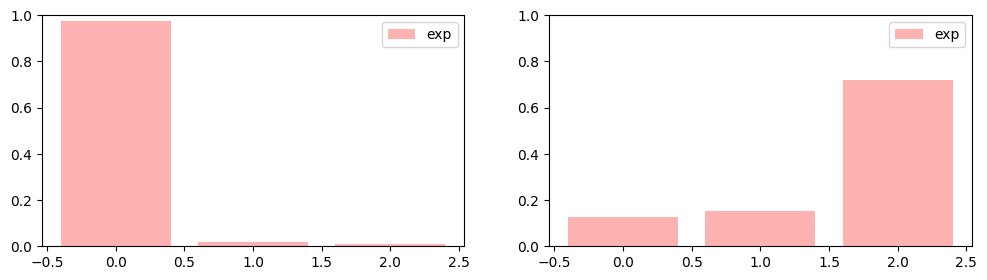

In [165]:
N = 3
alpha = 0.5
dirichlet_alpha = torch.full((N,),alpha)
stationary_0 = Dirichlet(dirichlet_alpha).sample((1,)).T
stationary_1 = Dirichlet(dirichlet_alpha).sample((1,)).T

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12, 3))

stationary_0_ = stationary_0.squeeze().detach().numpy()
stationary_1_ = stationary_1.squeeze().detach().numpy()

axs[0].bar(range(len( stationary_0_)), stationary_0_, color='red',alpha=0.3,label="exp")
axs[0].set_ylim(0,1)
axs[0].legend(loc="best")

axs[1].bar(range(len( stationary_1_)), stationary_1_,color='red',alpha=0.3,label="exp")
axs[1].set_ylim(0,1)
axs[1].legend(loc="best")
plt.show()

In [141]:
stationary_0

tensor([[0.6114],
        [0.3018],
        [0.0868]])

In [166]:
Q0 = obtain_Q(stationary_0.T,lambda_ = 1.)
Q1 = obtain_Q(stationary_1.T,lambda_ = 1.)

print(torch.matmul(stationary_0.T,Q0))
print(torch.matmul(stationary_1.T,Q1))

C:\Users\cesar\AppData\Local\Temp\ipykernel_2516\1577559833.py:57: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(output, zeros)


tensor([[-1.6564e-08, -1.6605e-08,  3.6809e-08]])
tensor([[2.6142e-09, 1.0548e-09, 1.6497e-09]])


In [174]:
R0 = Q0.clone()
R0[range(N),range(N)] = torch.zeros(N,)
R1 = Q1.clone()
R1[range(N),range(N)] = torch.zeros(N,)

print(R0.sum(axis=1),R1.sum(axis=1))


tensor([0.0866, 4.3028, 3.6399]) tensor([2.7676, 2.8909, 0.3705])


In [129]:
number_of_paths = 300 
number_of_times = 50
N = Q0.shape[0]
rescale = 10.

pi0_prior = Dirichlet(torch.full((N,),100.))
pi_0 = pi0_prior.sample((1,)).squeeze()
Q0,Q1 = Q0*rescale,Q1*rescale

X0 = Categorical(torch.Tensor(pi_0)).sample((number_of_paths,))

In [128]:
paths0,times0 = gillespie(X0,Q0,number_of_times=number_of_times)
paths1,times1 = gillespie(X0,Q1,number_of_times=number_of_times)

# set everything in a grid
time_grid = torch.arange(0,number_of_times,1,dtype=float)
paths0_grid,arrivals0 = states_at_grid(paths0.unsqueeze(-1), times0, time_grid)
paths1_grid,arrivals1 = states_at_grid(paths1.unsqueeze(-1), times0, time_grid)

paths0_grid = paths0_grid.squeeze()
paths1_grid = paths1_grid.squeeze()

histograms_on_time_0 = count_values_along_time(paths0_grid, N)
histograms_on_time_1 = count_values_along_time(paths1_grid, N)

histograms_on_time_0 = histograms_on_time_0/paths0_grid.shape[0]
histograms_on_time_1 = histograms_on_time_1/paths1_grid.shape[0]

hist0 = histograms_on_time_0[-1]
hist1 = histograms_on_time_1[-1]

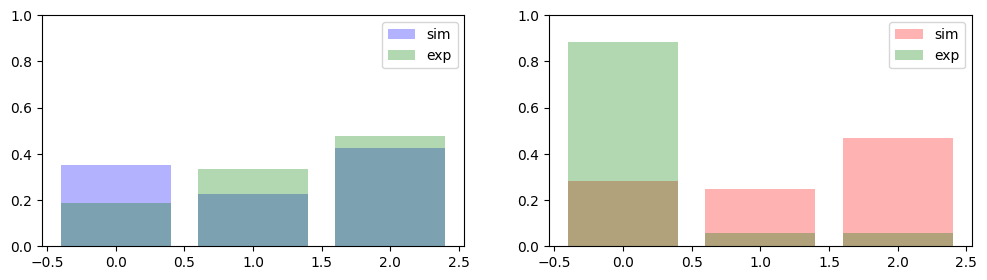

In [118]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12, 3))

stationary_0_ = stationary_0.squeeze().detach().numpy()
stationary_1_ = stationary_1.squeeze().detach().numpy()

axs[0].bar(range(len(hist0)), hist0, color='blue',alpha=0.3,label="sim")
axs[0].bar(range(len( stationary_0_)), stationary_0_, color='green',alpha=0.3,label="exp")
axs[0].set_ylim(0,1)
axs[0].legend(loc="best")

axs[1].bar(range(len(hist1)), hist1, color='red',alpha=0.3,label="sim")
axs[1].bar(range(len( stationary_1_)), stationary_1_,color='green',alpha=0.3,label="exp")
axs[1].set_ylim(0,1)
axs[1].legend(loc="best")
plt.show()

In [119]:
Q0

tensor([[-0.0020,  0.0010,  0.0010],
        [ 0.0050, -0.0102,  0.0052],
        [ 0.0010,  0.0010, -0.0020]])

In [120]:
Q1

tensor([[-0.0020,  0.0010,  0.0010],
        [ 0.0010, -0.3872,  0.3862],
        [ 0.0010,  0.0010, -0.0020]])

In [101]:
create_gif_histograms(histograms_on_time_0,histograms_on_time_1)

C:\Users\cesar\AppData\Local\Temp\ipykernel_2516\157615253.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
print(histograms_on_time_0[-1])
print(histograms_on_time_1[-1])

tensor([0.0000, 0.2767, 0.5267, 0.0000, 0.1967])
tensor([0.0067, 0.3300, 0.2000, 0.0933, 0.3700])


In [ ]:
print(histograms_on_time_0[0])
print(histograms_on_time_1[0])

tensor([0.2133, 0.0633, 0.2133, 0.2667, 0.2433])
tensor([0.2333, 0.1267, 0.0467, 0.2700, 0.3233])


# OPTIMAL TRANSPORT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ot  # Import Python Optimal Transport library

In [ ]:
def solve_regularized_transport(histogram_a,histogram_b):
    # Setting up the distributions
    # Uniform distribution of 10 points from 0 to 1
    n_points = histogram_a.shape[0]

    # Generate positions for each point in the distributions
    x = np.linspace(0, 1, n_points).reshape(-1, 1)  # Positions for a
    y = np.linspace(0, 1, n_points).reshape(-1, 1)  # Positions for b

    # Cost matrix: Euclidean distance
    C = ot.dist(x, y)
    C = C / C.max()  # Normalize cost for stability

    # Regularization parameter
    lambda_reg = 0.1  # Small lambda means more regularization

    # Solve the regularized optimal transport problem using Sinkhorn algorithm
    P = ot.sinkhorn(histogram_a, histogram_b, C, lambda_reg,numItermax=1000)

    # Compute the actual transport distance
    transport_distance = np.sum(P * C)  # Dot product of P and C
    
    return C,P,transport_distance

In [ ]:
def get_trasport_over_time(histograms_on_time_0,histograms_on_time_1):
    number_of_time_steps = histograms_on_time_0.shape[0]
    transport_cost_over_time = torch.zeros(number_of_time_steps)

    for time_index in range(number_of_time_steps):
        histogram_a = histograms_on_time_0[time_index].numpy()
        histogram_b = histograms_on_time_1[time_index].numpy()
        C,P,transport_distance = solve_regularized_transport(histogram_a,histogram_b)
        transport_cost_over_time[time_index] = transport_distance

    return transport_cost_over_time

In [ ]:
d_param = DirichletPriorOnRatesParam(concentration=0.01)
Q0 = generate_transition_rate_matrix(d_param)
Q1 = generate_transition_rate_matrix(d_param)
X0 = torch.randint(1,d_param.num_states,(300,))
TAU = np.linspace(0.,1.,10)

time_grid = torch.arange(0,101,1,dtype=float)
paths0,times0 = gillespie(X0,Q0,number_of_times=100)
paths0_grid,arrivals0 = states_at_grid(paths1.unsqueeze(-1), times0, time_grid)
paths0_grid = paths0_grid.squeeze()
histograms_on_time_0 = count_values_along_time(paths0_grid, d_param.num_states)
number_of_time_steps = histograms_on_time_0.shape[0]

for tau in TAU:
    print(f"Tau: {tau}")
    Q_tau = interpolation_tau*Q0 + (1.-interpolation_tau)*Q1
    paths1,times1 = gillespie(X0,Q_tau,number_of_times=100)

    # set everything in a grid
    paths1_grid,arrivals1 = states_at_grid(paths1.unsqueeze(-1), times0, time_grid)
    paths1_grid = paths1_grid.squeeze()

    histograms_on_time_1 = count_values_along_time(paths1_grid, d_param.num_states)
    histograms_on_time_1 = histograms_on_time_1/paths1_grid.shape[0]

    transport_over_time = get_trasport_over_time(histograms_on_time_0,histograms_on_time_1)
    print(transport_over_time.mean())

Tau: 0.0


c:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\ot\bregman\_sinkhorn.py:499: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
c:\Users\cesar\anaconda4\envs\rate_matching\lib\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 124
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


tensor(13.7929)
Tau: 0.1111111111111111
tensor(13.8747)
Tau: 0.2222222222222222
tensor(13.6804)
Tau: 0.3333333333333333
tensor(13.9385)
Tau: 0.4444444444444444
tensor(13.9176)
Tau: 0.5555555555555556
tensor(13.7662)
Tau: 0.6666666666666666
tensor(13.8569)
Tau: 0.7777777777777777
tensor(13.6817)
Tau: 0.8888888888888888
tensor(14.0167)
Tau: 1.0
tensor(13.8706)


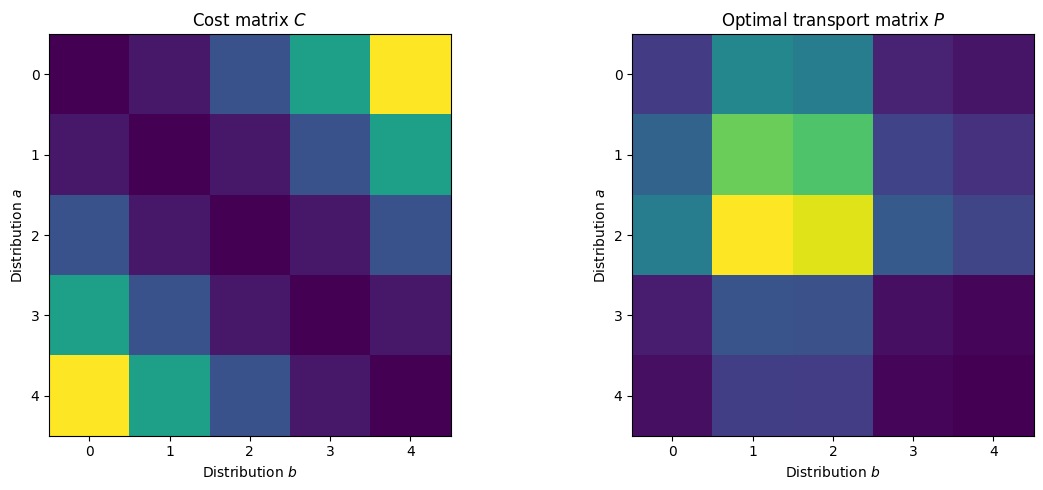

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot cost matrix
ax[0].imshow(C, interpolation='nearest')
ax[0].set_title('Cost matrix $C$')
ax[0].set_xlabel('Distribution $b$')
ax[0].set_ylabel('Distribution $a$')

# Plot optimal transport matrix
ax[1].imshow(P, interpolation='nearest')
ax[1].set_title('Optimal transport matrix $P$')
ax[1].set_xlabel('Distribution $b$')
ax[1].set_ylabel('Distribution $a$')

plt.tight_layout()
plt.show()